In [1]:
# Importação das bibliotecas principais para análise e modelagem

# Manipulação de dados e estruturas de DataFrame
import pandas as pd

# Operações numéricas e vetoriais
import numpy as np

# Visualização estatística com estilo aprimorado
import seaborn as sns

# Gráficos gerais e personalização de figuras
import matplotlib.pyplot as plt

# Normalização e transformação de variáveis
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# Regressão linear (base para o modelo polinomial)
from sklearn.linear_model import LinearRegression

# Métricas de avaliação de desempenho de modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Funções matemáticas e otimização (usadas em ajustes não lineares)
from scipy.optimize import curve_fit

# Configuração estética padrão dos gráficos
sns.set(style="whitegrid")

In [2]:
# Lê o dataset consolidado
df = pd.read_csv(
    r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\covid19_SP\SaS_Cov19_project\output\COVIDBR\COVIDBR_2020_2025_Consolidado.csv",
    sep=';',
    encoding='utf-8',
    low_memory=False
)

# Exibe as primeiras linhas
df.head()

,regiao,estado,municipio,coduf,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,interior/metropolitana
0,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-27,13,15256.0,0.0,0,0,0,0.0
1,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-28,13,15256.0,0.0,0,0,0,0.0
2,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-29,14,15256.0,2.0,2,0,0,0.0
3,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-30,14,15256.0,6.0,4,0,0,0.0
4,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-31,14,15256.0,7.0,1,0,0,0.0


In [3]:
# Converte a coluna de data e remove valores ausentes
df['data'] = pd.to_datetime(df['data'], errors='coerce')
df = df.dropna(subset=['casosNovos', 'semanaEpi'])
df

,regiao,estado,municipio,coduf,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,interior/metropolitana
0,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-27,13,15256.0,0.0,0,0,0,0.0
1,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-28,13,15256.0,0.0,0,0,0,0.0
2,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-29,14,15256.0,2.0,2,0,0,0.0
3,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-30,14,15256.0,6.0,4,0,0,0.0
4,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-31,14,15256.0,7.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11177054,Brasil,BR,Não informado,76,-1.0,Ignorado,2025-09-01,36,210147125.0,39318227.0,0,716626,0,Ignorado
11177055,Brasil,BR,Não informado,76,-1.0,Ignorado,2025-09-02,36,210147125.0,39318227.0,0,716626,0,Ignorado
11177056,Brasil,BR,Não informado,76,-1.0,Ignorado,2025-09-03,36,210147125.0,39318227.0,0,716626,0,Ignorado
11177057,Brasil,BR,Não informado,76,-1.0,Ignorado,2025-09-04,36,210147125.0,39318227.0,0,716626,0,Ignorado


## Modelo 1 - Regressão polinomial

In [5]:
# Seleciona apenas dados válidos e positivos
df = df[(df['casosNovos'] >= 0) & (df['populacaoTCU2019'] > 0)]

# Agrupa por semana epidemiológica (Brasil inteiro)
df_semana = df.groupby('semanaEpi', as_index=False)['casosNovos'].sum()

In [6]:
# Define variáveis de entrada (X) e saída (y)
X = df_semana[['semanaEpi']].values
y = df_semana['casosNovos'].values

In [7]:
# Remoção de outliers em 'casosNovos' com base no intervalo interquartílico (IQR)
q1, q3 = df_semana["casosNovos"].quantile([0.25, 0.75])
iqr = q3 - q1
limite_superior = q3 + 1.5 * iqr
df_semana = df_semana[df_semana["casosNovos"] <= limite_superior]

# Definição das variáveis independentes (X) e dependentes (y)
# X representa a semana epidemiológica, y representa o número de casos novos
X = df_semana["semanaEpi"].values.reshape(-1, 1)
y = df_semana["casosNovos"].values

# Avaliação de diferentes graus de regressão polinomial
print("Avaliação do desempenho por grau de polinômio:\n")

best_r2 = -1.0
best_degree = None

# Teste dos graus de 2 a 10 e escolha do melhor R²
for degree in range(2, 11):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)

    print(f"Grau {degree}: R² = {r2:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_degree = degree

# Exibição do melhor grau de polinômio com maior R²
print(f"\nMelhor desempenho: grau {best_degree} (R² = {best_r2:.4f})")

Avaliação do desempenho por grau de polinômio:

Grau 2: R² = 0.5549
Grau 3: R² = 0.5610
Grau 4: R² = 0.6054
Grau 5: R² = 0.6131
Grau 6: R² = 0.8816
Grau 7: R² = 0.9017
Grau 8: R² = 0.8135
Grau 9: R² = 0.7808
Grau 10: R² = 0.7088

Melhor desempenho: grau 7 (R² = 0.9017)


In [8]:
# Cria a transformação polinomial com o melhor grau identificado
poly_best = PolynomialFeatures(degree=best_degree)
X_poly_best = poly_best.fit_transform(X)

# Treina o modelo de regressão linear sobre os dados polinomiais
model_best = LinearRegression()
model_best.fit(X_poly_best, y)

# Gera as previsões do modelo ajustado
y_pred_best = model_best.predict(X_poly_best)

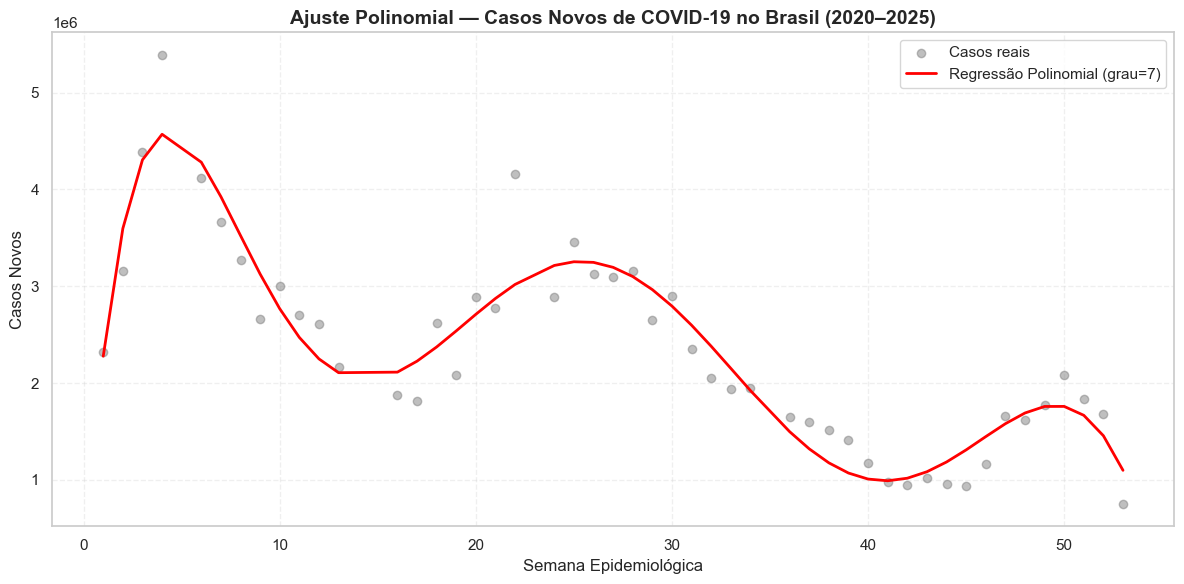

MAE: 385083.93
RMSE: 543186.56
R²: 0.7088


In [15]:
# Cria a figura e define o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Plota os pontos reais dos casos observados
plt.scatter(X, y, color="gray", alpha=0.5, label="Casos reais")

# Plota a curva da regressão polinomial ajustada
plt.plot(
    X,
    y_pred_best,
    color="red",
    linewidth=2,
    label=f"Regressão Polinomial (grau={best_degree})"
)

# Define título e rótulos dos eixos
plt.title(
    "Ajuste Polinomial — Casos Novos de COVID-19 no Brasil (2020–2025)",
    fontsize=14,
    weight="bold"
)
plt.xlabel("Semana Epidemiológica")
plt.ylabel("Casos Novos")

# Exibe legenda e grade de fundo
plt.legend()
plt.grid(alpha=0.3, linestyle="--")

# Ajusta o layout para evitar sobreposição e exibe o gráfico
plt.tight_layout()
plt.show()

# Avaliação do modelo
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

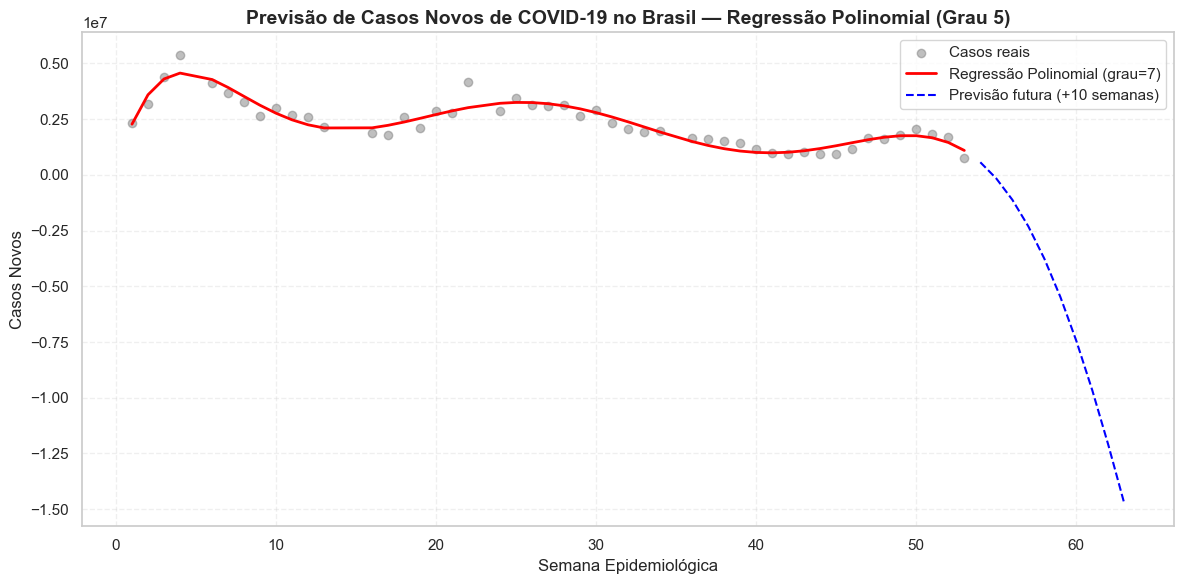

MAE: 385083.93
RMSE: 543186.56
R²: 0.7088


In [16]:
# Define o intervalo de semanas futuras (+10 semanas)
future_weeks = np.arange(
    df_semana["semanaEpi"].max() + 1,
    df_semana["semanaEpi"].max() + 11
).reshape(-1, 1)

# Aplica a transformação polinomial nas semanas futuras
future_poly = poly_best.transform(future_weeks)

# Gera previsões para as próximas 10 semanas
future_pred = model_best.predict(future_poly)

# Cria a figura para o gráfico de previsão
plt.figure(figsize=(12, 6))

# Plota os dados reais observados
plt.scatter(X, y, color="gray", alpha=0.5, label="Casos reais")

# Plota a curva ajustada do modelo polinomial
plt.plot(
    X,
    y_pred_best,
    color="red",
    linewidth=2,
    label=f"Regressão Polinomial (grau={best_degree})"
)

# Plota a previsão futura (+10 semanas)
plt.plot(
    future_weeks,
    future_pred,
    color="blue",
    linestyle="--",
    label="Previsão futura (+10 semanas)"
)

# Define título e rótulos dos eixos
plt.title(
    "Previsão de Casos Novos de COVID-19 no Brasil — Regressão Polinomial (Grau 5)",
    fontsize=14,
    weight="bold"
)
plt.xlabel("Semana Epidemiológica")
plt.ylabel("Casos Novos")

# Exibe legenda e grade de fundo
plt.legend()
plt.grid(alpha=0.3, linestyle="--")

# Ajusta o layout e exibe o gráfico
plt.tight_layout()
plt.show()

# Avaliação do modelo
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


## Modelo 2 - Regressão logistica

In [12]:
# Lê o arquivo CSV consolidado com dados da COVID-19
csv_path = (
    r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\covid19_SP"
    r"\SaS_Cov19_project\output\COVIDBR\COVIDBR_2020_2025_Consolidado.csv"
)

# Carrega o dataset no DataFrame
df = pd.read_csv(
    csv_path,
    sep=";",
    encoding="utf-8",
    low_memory=False
)

# Converte a coluna de datas para o tipo datetime
df["data"] = pd.to_datetime(df["data"], errors="coerce")

# Exibe o DataFrame carregado
df

,regiao,estado,municipio,coduf,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,interior/metropolitana
0,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-27,13,15256.0,0.0,0,0,0,0.0
1,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-28,13,15256.0,0.0,0,0,0,0.0
2,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-29,14,15256.0,2.0,2,0,0,0.0
3,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-30,14,15256.0,6.0,4,0,0,0.0
4,Norte,AC,Acrelândia,12,12002.0,BAIXO ACRE E PURUS,2020-03-31,14,15256.0,7.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11177054,Brasil,BR,Não informado,76,-1.0,Ignorado,2025-09-01,36,210147125.0,39318227.0,0,716626,0,Ignorado
11177055,Brasil,BR,Não informado,76,-1.0,Ignorado,2025-09-02,36,210147125.0,39318227.0,0,716626,0,Ignorado
11177056,Brasil,BR,Não informado,76,-1.0,Ignorado,2025-09-03,36,210147125.0,39318227.0,0,716626,0,Ignorado
11177057,Brasil,BR,Não informado,76,-1.0,Ignorado,2025-09-04,36,210147125.0,39318227.0,0,716626,0,Ignorado


In [13]:
# Agrupa os dados por data e soma os casos acumulados para todo o Brasil
df_brasil = (
    df.groupby("data")[["casosAcumulado"]]
    .sum()
    .reset_index()
    .sort_values("data")
)

# Remove valores nulos e anômalos (casos menores ou iguais a zero)
df_brasil = df_brasil[df_brasil["casosAcumulado"] > 0]

# Cria um eixo temporal contínuo para modelagem (dias desde o início da série)
df_brasil["t"] = np.arange(len(df_brasil))

# Exibe as primeiras linhas do DataFrame agregado
df_brasil.head(10)

,data,casosAcumulado,t
1,2020-02-26,2.0,0
2,2020-02-27,2.0,1
3,2020-02-28,2.0,2
4,2020-02-29,4.0,3
5,2020-03-01,4.0,4
6,2020-03-02,4.0,5
7,2020-03-03,4.0,6
8,2020-03-04,6.0,7
9,2020-03-05,14.0,8
10,2020-03-06,26.0,9


In [17]:
# Agrega os dados nacionais de óbitos acumulados por data
df_brasil = (
    df.groupby("data")[["obitosAcumulado"]]
    .sum()
    .reset_index()
    .sort_values("data")
)

# Remove valores nulos ou inconsistentes
df_brasil = df_brasil[df_brasil["obitosAcumulado"] > 0]

# Cria eixo temporal contínuo (dias desde o início da série)
df_brasil["t"] = np.arange(len(df_brasil))


# Define o modelo logístico epidemiológico clássico
def logistic_model(t, K, r, t0):
    """Retorna os valores previstos segundo a equação logística:
    y(t) = K / (1 + exp(-r * (t - t0))),
    onde:
        K  = limite máximo (capacidade total),
        r  = taxa de crescimento,
        t0 = ponto de inflexão.
    """
    return K / (1 + np.exp(-r * (t - t0)))


# Define palpites iniciais para os parâmetros
K0 = df_brasil["obitosAcumulado"].max() * 1.2  # limite superior inicial
r0 = 0.05  # taxa de crescimento inicial
t0 = len(df_brasil) / 2  # ponto médio inicial
params_init = [K0, r0, t0]

# Ajusta os parâmetros via mínimos quadrados não lineares
params_opt, _ = curve_fit(
    logistic_model,
    df_brasil["t"],
    df_brasil["obitosAcumulado"],
    p0=params_init,
    maxfev=10000
)

# Extrai os parâmetros ajustados
K_fit, r_fit, t0_fit = params_opt

In [18]:
# Cria um eixo temporal estendido para previsão dos próximos 60 dias
t_future = np.arange(len(df_brasil) + 60)

# Gera as previsões com base nos parâmetros ajustados do modelo logístico
y_pred = logistic_model(t_future, K_fit, r_fit, t0_fit)

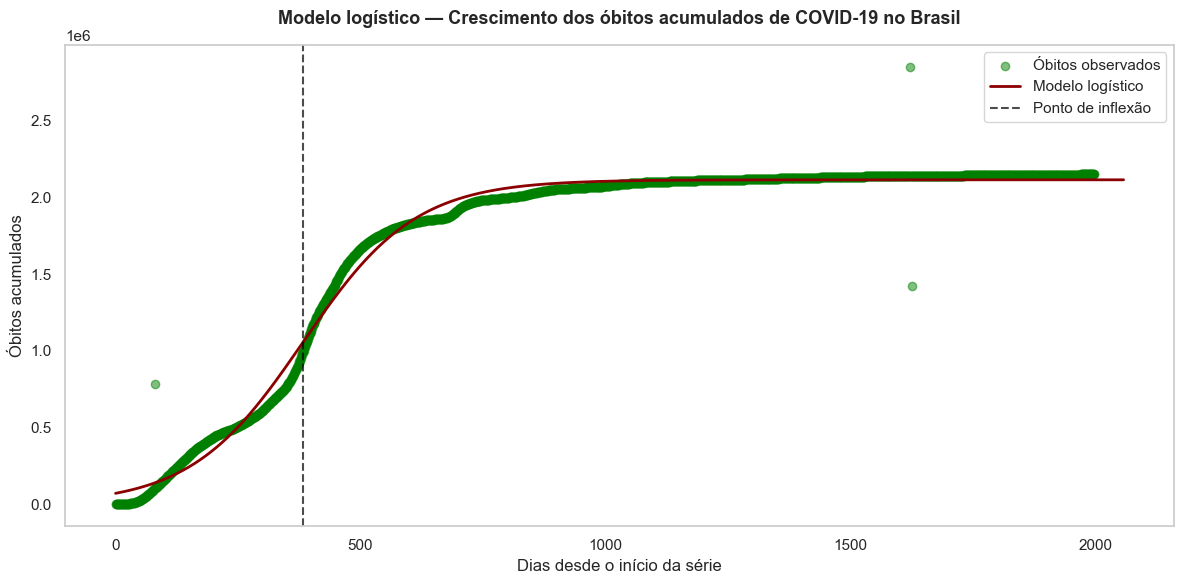


Métricas de desempenho (óbitos):
MAE  = 41,254
RMSE = 57,241
R²   = 0.9928

Parâmetros estimados (óbitos):
K  (limite máximo)          ≈ 2,115,150
r  (taxa de crescimento)    ≈ 0.0087
t₀ (ponto de inflexão)      ≈ 383º dia


In [22]:
# Avalia o desempenho do modelo logístico com base nos dados observados
y_true = df_brasil["obitosAcumulado"]
y_hat = logistic_model(df_brasil["t"], K_fit, r_fit, t0_fit)

mae = mean_absolute_error(y_true, y_hat)
rmse = np.sqrt(mean_squared_error(y_true, y_hat))
r2 = r2_score(y_true, y_hat)

# Visualiza o ajuste do modelo logístico em relação aos dados observados
plt.figure(figsize=(12, 6))
plt.scatter(
    df_brasil["t"],
    df_brasil["obitosAcumulado"],
    color="green",
    alpha=0.5,
    label="Óbitos observados"
)
plt.plot(
    t_future,
    y_pred,
    color="darkred",
    linewidth=2,
    label="Modelo logístico"
)
plt.axvline(
    t0_fit,
    color="black",
    linestyle="--",
    alpha=0.7,
    label="Ponto de inflexão"
)

plt.title(
    "Modelo logístico — Crescimento dos óbitos acumulados de COVID-19 no Brasil",
    fontsize=13,
    weight="bold",
    pad=15
)
plt.xlabel("Dias desde o início da série")
plt.ylabel("Óbitos acumulados")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

print("\nMétricas de desempenho (óbitos):")
print(f"MAE  = {mae:,.0f}")
print(f"RMSE = {rmse:,.0f}")
print(f"R²   = {r2:.4f}")


# Exibe os parâmetros ajustados do modelo
print("\nParâmetros estimados (óbitos):")
print(f"K  (limite máximo)          ≈ {K_fit:,.0f}")
print(f"r  (taxa de crescimento)    ≈ {r_fit:.4f}")
print(f"t₀ (ponto de inflexão)      ≈ {t0_fit:.0f}º dia")